# Michael divers: vorticity, k-omega spectra

In [ ]:
import os

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

import xgcm

import mitequinox.utils as ut
import mitequinox.plot as pl
#import mitequinox.sigp as sp

In [ ]:
localcluster = True

if localcluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    #w = cluster.scale(jobs=5) # enough for a couple of locations
    # for full face filtering:
    cluster = PBSCluster(cores=12, processes=6)
    w = cluster.scale(jobs=30)

client = Client(cluster)
client

---

## load mit4320 data

In [3]:
# original dataset (not rechunked)
#ds = ut.load_data(["Eta", "SSU", "SSV"])
grd = ut.load_grd()

# add coriolis parameters to dataset
f = 2*ut.omega_earth*np.sin(np.deg2rad(grd['YG'])) # at vorticity points
grd = grd.assign_coords(f=f)

In [4]:
zarr = os.path.join(ut.root_data_dir, "rechunked", "SSU.zarr")
dsU = xr.open_zarr(zarr)
zarr = os.path.join(ut.root_data_dir, "rechunked", "SSV.zarr")
dsV = xr.open_zarr(zarr)

ds0 = xr.merge([dsU, dsV]).assign_coords(grd.coords)

In [5]:
# geographically subsample in a 500km x 500km region
i, j = slice(2500,2750), slice(500,750)
ds = ds0.isel(face=7, i_g=i, i=i, j=j, j_g=j)

# temporally subsample over one month
ds = ds.sel(time="2012-02")

# rechunk
ds = ds.chunk(dict(time=24*5, i_g=-1)).persist()

### compute vorticity

Reference [xgcm doc](https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html)

In [6]:
# load xgcm grid object
xgrid = xgcm.Grid(ds) # , periodic=['X', 'Y']

coords = None


In [7]:
ds["zeta"] = (
    (-xgrid.diff(ds.SSU * ds.dxC, 'Y') 
     + xgrid.diff(ds.SSV * ds.dyC, 'X')
    )/ds.rAz
).persist()

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


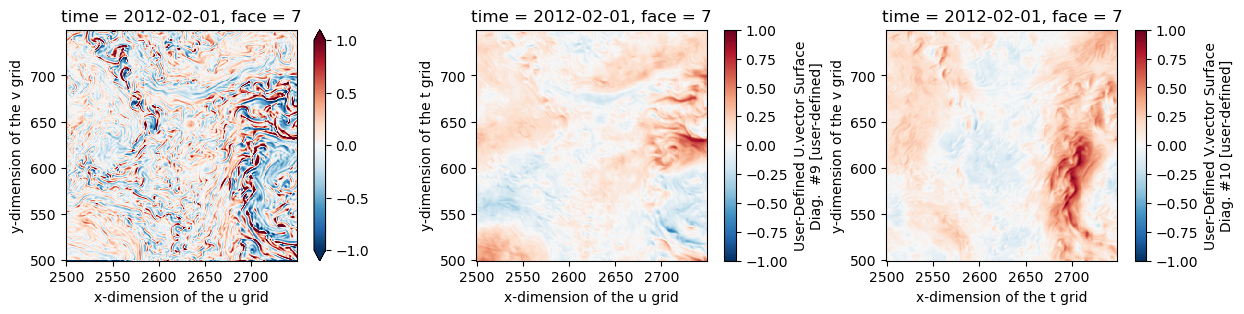

In [8]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
(ds["zeta"]/ds["f"]).isel(time=0).plot(ax=axes[0], vmax=1.)
axes[0].set_aspect("equal")
ds["SSU"].isel(time=0).plot(ax=axes[1], vmax=1.)
axes[1].set_aspect("equal")
ds["SSV"].isel(time=0).plot(ax=axes[2], vmax=1.)
axes[2].set_aspect("equal")

### k-omega spectra

In [9]:
import xrft

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# swap dates/time
ds = ds.assign_coords(dates=ds.time)
ds = ds.assign_coords(
    time=(ds["time"] - np.datetime64("2011-11-01"))
    /pd.Timedelta("1D").to_timedelta64()
)

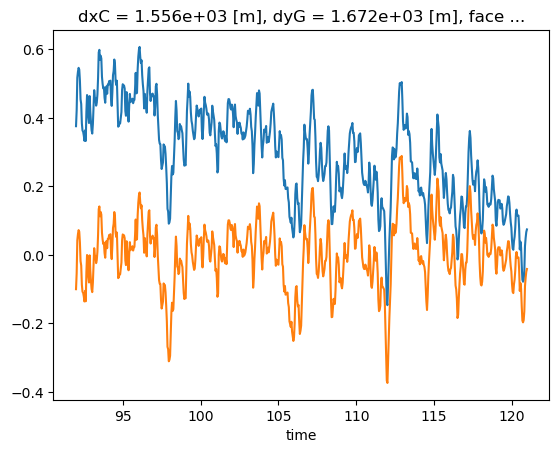

In [10]:
# illustrates importance of detrending
da = ds.SSU
da = detrend_dim(da, "time").persist()

ds.SSU.isel(i_g=0, j=0).plot()
da.isel(i_g=0, j=0).plot()

In [11]:
#with ProgressBar():

def get_spectrum(da):

    if "i_g" in da.dims:
        # SSU
        da = (
            da.drop_vars(['dxC', 'dyG', 'rAw', 'dates'])
            .rename(i_g="i")
        )
    elif "j_g" in da.dims:
        # SSU
        da = (
            da.drop_vars(['dyC', 'dxG', 'rAs', 'dates'])
            .rename(j_g="j")
        )
    da = da.chunk(time=-1, i=-1, j=-1)
        
    # manually detrend (xrft requires full chunks for detrending)
    da = detrend_dim(da, "time")
    da = detrend_dim(da, "i") 
    da = detrend_dim(da, "j") 
    
    xhat = xrft.power_spectrum(
        da,
        dim=da.dims, 
        #detrend='linear', 
        window="hamming",
    ).compute()

    # isotropize spectrum
    xhat_iso = xrft.isotropize(xhat, ["freq_i", "freq_j"])
    
    dx = 2 # km, approximate
    xhat_iso["freq_r"] = xhat_iso["freq_r"]/dx

    return xhat_iso

In [12]:
Eu = get_spectrum(ds.SSU)
Ev = get_spectrum(ds.SSV)
E = 0.5*(Eu+Ev)

/dev/shm/pbs.8490395.datarmor0/ipykernel_33913/1082658395.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da.drop(['dxC', 'dyG', 'rAw', 'dates'])
/dev/shm/pbs.8490395.datarmor0/ipykernel_33913/1082658395.py:14: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da.drop(['dyC', 'dxG', 'rAs', 'dates'])


(0.0, 4.0)

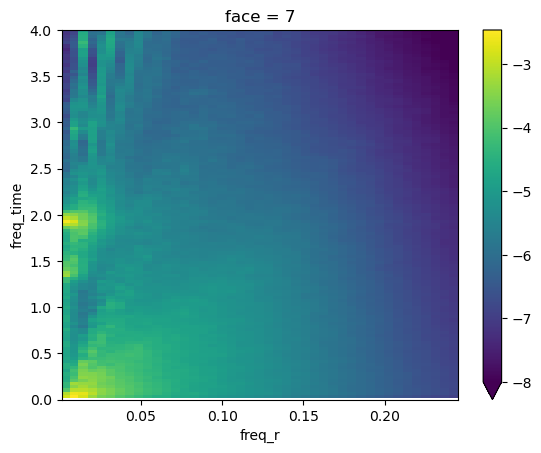

In [13]:
fig, ax = plt.subplots(1,1)
da = E.where(E.freq_time>0, drop=True)
da = np.log10(da)
da.plot(ax=ax, vmin=-8)
#ax.set_xscale("log")
ax.set_ylim(0,4)